In [34]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 500)

In [77]:
tickers = tickers = [
        "AAPL",
        "META",
        "AMZN",
        "MSFT",
        "GOOG",
        "GS",
        "XOM",
        "RBLX",
        "GME",
        "FRGT",
        "GTLB",
        "WFC",
        "NVDA",
        "JPM",
        "GME",
        "TSLA",
        "PD",
        "JNJ",
        "LMH",
        "BBBY",
        "COST",
        "SI",
        "RKT",
    ]

In [78]:
data = yf.download(tickers, start="2010-01-01")["Adj Close"]

[*********************100%***********************]  22 of 22 completed


In [79]:
# calculate and scale returns
returns = data.pct_change().dropna()
returns_scaled = (returns - returns.mean()) / returns.std()

# create covariance matrix
returns_cov = returns_scaled.cov()

In [80]:
# fit PCA, with the number of components == number of assets
# num_comp = len(data.columns)
pca = PCA()
pca.fit(returns_cov)

PCA()

In [81]:
# get the variance % and ratio
variance_percent = pd.DataFrame(data=pca.explained_variance_)
variance_ratio = pd.DataFrame(data=(pca.explained_variance_ratio_ * 100))

In [82]:
# understand how many components make up the combined variance
var_threshold = 0.85

var_explained_norm = np.cumsum(pca.explained_variance_ratio_)
num_comp_norm = (
    np.where(np.logical_not(var_explained_norm < var_threshold))[0][0] + 1
)  # +1 due to zero based-arrays
print(
    "%d components explain %.2f%% of variance (NORMALISED)"
    % (num_comp_norm, 100 * var_threshold)
)
variance_ratio.T

6 components explain 85.00% of variance (NORMALISED)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,52.826289,14.812437,7.48628,4.545296,3.605643,3.20857,2.613619,2.427863,1.738654,1.369401,1.06787,0.978227,0.916752,0.633897,0.444239,0.329348,0.308684,0.244406,0.174682,0.160085,0.107758,2.293027e-31


In [83]:
# get eigen values
loadings = pca.components_.T
eigenvalues = np.sqrt(pca.explained_variance_)

In [84]:
# calculate weights
weights = loadings * eigenvalues
weights = weights / np.abs(weights).sum(axis=0)

In [85]:
# combine multiple components to get the weights of said components
combined_weights = weights[:, 0] + weights[:, (num_comp_norm + 1)]
combined_weights = abs(combined_weights / np.abs(combined_weights).sum())

combined_weights = combined_weights.reshape(1, len(data.columns))

In [86]:
# construct dataframe
portfolio = pd.DataFrame(data=combined_weights, columns=data.columns)
portfolio

,AAPL,AMZN,BBBY,COST,FRGT,GME,GOOG,GS,GTLB,JNJ,JPM,LMH,META,MSFT,NVDA,PD,RBLX,RKT,SI,TSLA,WFC,XOM
0,0.032473,0.022758,0.079046,0.048702,0.027299,0.067223,0.004282,0.037966,0.099641,0.056747,0.052376,0.007057,0.033076,0.02044,0.043371,0.07749,0.058379,0.057829,0.021888,0.063173,0.035355,0.053428


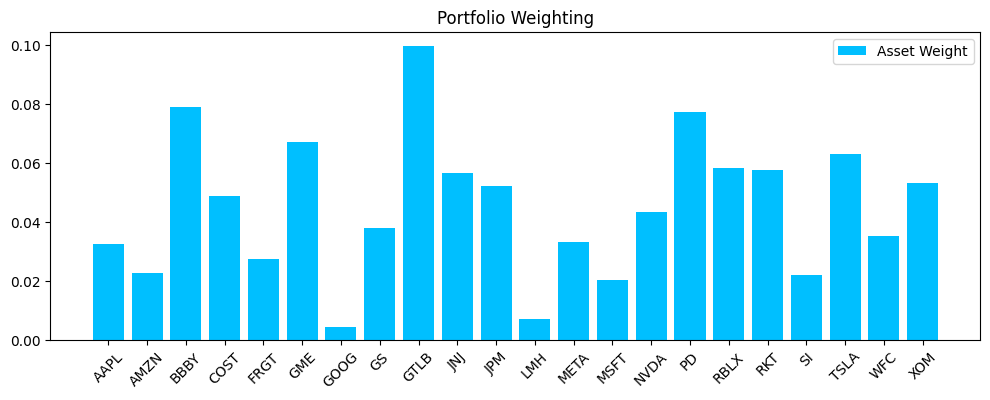

In [87]:
# visualise portfolio
x_indx = np.arange(len(portfolio.columns))

fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

rects = ax.bar(
            x_indx,
            portfolio.values.flatten(),
            color="deepskyblue",
        )

ax.set_xticks(x_indx)
ax.set_xticklabels(data.columns, rotation=45)
ax.set_title("Portfolio Weighting")
ax.legend((rects[0],), ("Asset Weight",))